## Translating DBpedia queries to Wikidata with LLMs **Baseline model**

In [1]:
# import libraries
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from openai import OpenAI

In [2]:
# Load the dataset from 100_complete_entries
with open("../../../data/100_complete_entries.json", "r") as file:
    data = json.load(file)

# Create input dataset for the baseline model
baseline_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")  # Natural language question
    dbpedia_query = entry.get("dbpedia_query", "")  # SPARQL query for DBpedia

    # Construct the input for the baseline model
    baseline_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": dbpedia_query,
            "kg1_name": "DBpedia",
            "kg2_name": "Wikidata",
            "instruction": "Given the information above, produce a SPARQL query for KG2. In your answer please highlight the final, complete SPARQL query within the tags '<sparql>' and '</sparql>'."
        }
    }
    baseline_inputs.append(baseline_input)

# Save the processed dataset to a new JSON file
with open("baseline_input_dbpedia_wikidata.json", "w") as file:
    json.dump(baseline_inputs, file, indent=4)

print(f"Baseline dataset saved to 'baseline_input_dbpedia_wikidata.json'.")


Baseline dataset saved to 'baseline_input_dbpedia_wikidata.json'.


## Running meta-llama-3.1-8b-instruct with 100 queries
The model includes 8billion parameters and is one of the smallest available models at Academic Cloud.

In [ ]:
# Set up the LLM API connection to academiccloud
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("baseline_input_dbpedia_wikidata.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text 
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question: {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("baseline_output_llama_dbpedia_wikidata.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'baseline_output_llama_dbpedia_wikidata.json'.")


Translated SPARQL queries for all questions saved to 'baseline_output_llama_dbpedia_wikidata.json'.


## Running Mistral-Large-instruct with 100 queries
The model includes 123billion parameters and is the largest available model at Academic Cloud https://chat-ai.academiccloud.de

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
input_file_path = "baseline_input_dbpedia_wikidata.json"
output_file_path = "baseline_output_mistral_dbpedia_wikidata.json"

with open(input_file_path, "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": {
                "natural_language_question": context["natural_language_question"],
                "sparql_query_kg1": context["sparql_query_kg1"],
                "kg1_name": context["kg1_name"],
                "kg2_name": context["kg2_name"],
                "instruction": context["instruction"]
            },
            "sparql_query_kg2": response_text
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question: {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open(output_file_path, "w") as file:
    json.dump(translated_dataset, file, indent=4)

print(f"Translated SPARQL queries for all questions saved to '{output_file_path}'.")

Translated SPARQL queries for all questions saved to 'baseline_output_mistral_dbpedia_wikidata.json'.


## Analysis of the results

Extracting the SPARQL queries from LLM output for **mistral-large-instruct**

In [12]:
def extract_sparql_queries(llm_output):
    """
    Extracts the final SPARQL query from the LLM output.
    Handles cases where queries are enclosed within <sparql>...</sparql> tags or ```sparql``` blocks.
    Removes inline comments marked with # before any other processing.
    """
    # First, remove inline comments
    llm_output = re.sub(r"# .*?(\n|$)", "\n", llm_output)
    
    # Regex pattern to capture content between <sparql> and </sparql>
    pattern_sparql_tags = r"<sparql>(.*?)</sparql>"
    matches_sparql_tags = re.findall(pattern_sparql_tags, llm_output, re.DOTALL)
    
    if matches_sparql_tags:
        query = " ".join(matches_sparql_tags[-1].replace("\n", " ").split())
    else:
        # Regex pattern to capture content between ```sparql``` blocks
        pattern_code_block = r"```sparql(.*?)```"
        matches_code_block = re.findall(pattern_code_block, llm_output, re.DOTALL)
        
        if matches_code_block:
            query = " ".join(matches_code_block[-1].replace("\n", " ").split())
        else:
            # Alternative extraction for inline SPARQL queries
            pattern_inline = r"(PREFIX .*?SELECT .*? WHERE \{.*?\})"
            matches_inline = re.findall(pattern_inline, llm_output, re.DOTALL)
            
            query = " ".join(matches_inline[-1].replace("\n", " ").split()) if matches_inline else ""
    
    # Remove trailing </sparql> tags if still present
    query = re.sub(r"</sparql>$", "", query).strip()
    
    return query

def process_input_file(input_file, output_file):
    """
    Reads the input JSON file, processes the data, extracts SPARQL queries,
    removes inline comments, and writes the cleaned data to an output JSON file.
    Also prints statistics on extraction success.
    """
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    cleaned_data = []
    failed_queries = []
    total_entries = len(data)
    extracted_count = 0
    
    for entry in data:
        context = entry.get("context", {})
        natural_language_question = context.get("natural_language_question", "")
        
        # Extract and clean the final SPARQL query
        llm_output = entry.get("sparql_query_kg2", "")
        final_sparql_query = extract_sparql_queries(llm_output)
        
        if final_sparql_query:
            cleaned_data.append({
                "natural_language_question": natural_language_question,
                "sparql_query_kg2": final_sparql_query
            })
            extracted_count += 1
        else:
            failed_queries.append({
                "natural_language_question": natural_language_question,
                "sparql_query_raw": llm_output
            })
    
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(cleaned_data, f, indent=2)
    
    # Calculate statistics
    failed_count = total_entries - extracted_count
    success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0

    # Print statistics
    print(f"Processed {total_entries} entries and saved to {output_file}.")
    print(f"Total entries processed: {total_entries}")
    print(f"Successfully extracted queries: {extracted_count}")
    print(f"Failed queries: {failed_count}")
    print(f"Extraction success rate: {success_rate:.2f}%")

if __name__ == "__main__":
    input_file = "baseline_output_mistral_dbpedia_wikidata.json"
    output_file = "baseline_mistral_dbpedia_wikidata_extracted.json"
    process_input_file(input_file, output_file)

Processed 100 entries and saved to baseline_mistral_dbpedia_wikidata_extracted.json.
Total entries processed: 100
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%


Extracting the SPARQL queries from LLM output for **lama-3.1-8b-instruct**.

In [5]:
input_file_path = 'baseline_output_llama_dbpedia_wikidata.json'
output_file_path = 'baseline_llama_dbpedia_wikidata_extracted.json'

# Load the JSON file
with open(input_file_path, 'r') as file:
    data = json.load(file)

# Function to extract and clean SPARQL queries
def extract_and_clean_sparql_query(sparql_raw):
    try:
        # First, remove inline comments marked with #
        sparql_raw = re.sub(r"# .*?(\n|$)", "\n", sparql_raw)
        
        # Skip unnecessary patterns
        sparql_raw = re.sub(r"'<sparql>' and '</sparql>'", "", sparql_raw)
        sparql_raw = re.sub(r"`<sparql>` and `</sparql>`", "", sparql_raw)

        # Normalize common SPARQL misspellings in tags (e.g., `<spdql>`)
        sparql_raw = re.sub(r"<\s*spdql\s*>", "<sparql>", sparql_raw)
        sparql_raw = re.sub(r"</\s*spdql\s*>", "</sparql>", sparql_raw)

        # Look for properly formatted SPARQL queries within <sparql> tags
        sparql_match = re.search(r"<\s*sparql\s*>(.*?)</\s*sparql\s*>", sparql_raw, re.DOTALL)

        # Handle SPARQL queries written inside markdown-like `sparql` backticks
        if not sparql_match:
            sparql_match = re.search(r"`sparql`\s*(SELECT .*?)\s*`sparql`", sparql_raw, re.DOTALL)

        # Handle SPARQL queries enclosed within triple backticks (```sparql```)
        if not sparql_match:
            sparql_match = re.search(r"```sparql\s*(.*?)\s*```", sparql_raw, re.DOTALL)

        # Handle PREFIX-based queries without specific enclosing tags
        if not sparql_match:
            sparql_match = re.search(r"(PREFIX.*?WHERE\s*\{.*?\})", sparql_raw, re.DOTALL)

        # Handle raw SELECT queries that follow a descriptive lead-in
        if not sparql_match:
            sparql_match = re.search(r"(SELECT\s+\?.*?\{.*?\})", sparql_raw, re.DOTALL)

        if sparql_match:
            query = sparql_match.group(1).strip()
            query = re.sub(r"\s+", " ", query).strip()  # Remove excessive whitespace
            return query
    except Exception as e:
        print(f"Error cleaning SPARQL query: {e}")
    
    return None

# Initialize results tracking
result = []
failed_queries = []
total_entries = len(data)
extracted_count = 0

# Process all entries and keep natural language question with the query
for entry in data:
    context = entry.get('context', {})
    natural_language_question = context.get('natural_language_question', None)
    sparql_query_raw = entry.get('sparql_query_kg2', '')

    # Extract and clean the SPARQL query
    sparql_query = extract_and_clean_sparql_query(sparql_query_raw)

    if natural_language_question and sparql_query:
        result.append({
            "natural_language_question": natural_language_question,
            "sparql_query": sparql_query
        })
        extracted_count += 1
    else:
        failed_queries.append({
            "natural_language_question": natural_language_question,
            "sparql_query_raw": sparql_query_raw
        })

# Save the successfully extracted queries to a new JSON file
with open(output_file_path, 'w') as output_file:
    json.dump(result, output_file, indent=4)

# Print statistics
failed_count = total_entries - extracted_count
success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0

print(f"Cleaned and extracted data has been saved to {output_file_path}.")
print(f"Total entries processed: {total_entries}")
print(f"Successfully extracted queries: {extracted_count}")
print(f"Failed queries: {failed_count}")
print(f"Extraction success rate: {success_rate:.2f}%")

Cleaned and extracted data has been saved to baseline_llama_dbpedia_wikidata_extracted.json.
Total entries processed: 100
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%


## Run the extracted SPARQL queries on Wikidata
Results for **mistral-large-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Prefix wikibase was not registered using a PREFIX declaration",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 201,\n        "query": "PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/> SELECT DISTINCT ?musical ?musicalLabel WHERE { ?musical wdt:P31 wd:Q1346457; wdt:P175 wd:Q40703. SERVICE wikibase:label { bd:serviceParam wikibase:language \\"[AUTO_LANGUAGE],en\\". } }",\n        "startIndex": 201,\n        "stopIndex": 214\n    },\n    "query": "PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/> SELECT DISTINCT ?musical ?musicalLabel WHERE { ?musical wdt:P31 wd:Q1346457; wdt:P175 wd:Q40703. SERVICE wikibase:label { bd:serviceParam wikibase:language \\"[AUTO_LANGUAGE],en\\". } }",\n    "resultsize": 0,\n   

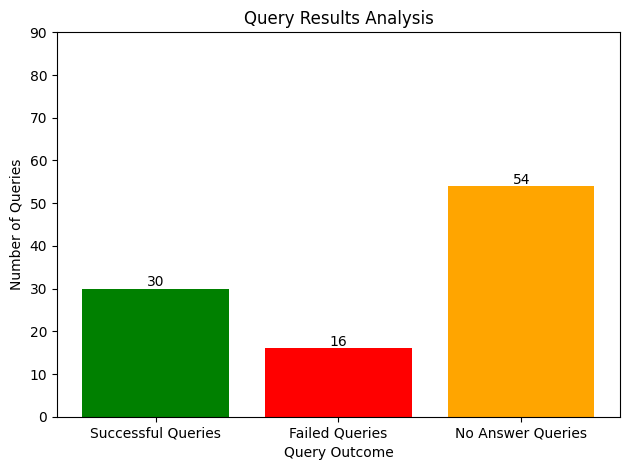

In [6]:
# File paths
input_file_path = "baseline_mistral_dbpedia_wikidata_extracted.json"
output_file_path = "baseline_mistral_dbpedia_wikidata_executed.json"

# Wikidata local endpoint
WIKIDATA_ENDPOINT = "http://localhost:7001"

# Define prefixes for the queries
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query_kg2", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the Wikidata endpoint
    results = query_sparql(WIKIDATA_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
plt.ylim(0, 90)
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

Results for **lama-3.1-8b-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"p179\\": mismatched input \'p179\' expecting {\'(\', \'[\', \'true\', \'false\', IRI_REF, PNAME_NS, PNAME_LN, BLANK_NODE_LABEL, VAR1, VAR2, PREFIX_LANGTAG, INTEGER, DECIMAL, DOUBLE, INTEGER_POSITIVE, DECIMAL_POSITIVE, DOUBLE_POSITIVE, INTEGER_NEGATIVE, DECIMAL_NEGATIVE, DOUBLE_NEGATIVE, STRING_LITERAL1, STRING_LITERAL2, STRING_LITERAL_LONG1, STRING_LITERAL_LONG2, NIL, ANON}",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 262,\n        "query": "PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX ps: <http://www.wikidata.org/prop/statement/> PREFIX p: <http://www.wikidata.org/prop/> PREFIX o: <http://www.wikidata.org/prop/ontology/> SELECT DISTINCT ?uri WHERE { ?uri wdt:P31 wd:Q11424; p:statement p179; ps:P179 ?film. BIND(?film AS ?uri). }",\n        "startIndex": 262,\n        "s

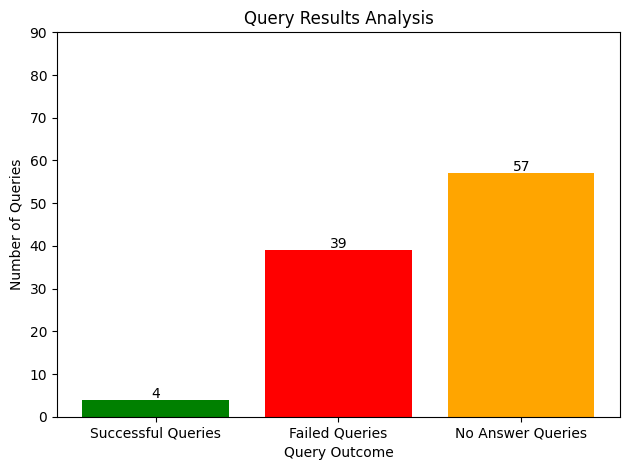

In [7]:
# File paths
input_file_path = "baseline_llama_dbpedia_wikidata_extracted.json"
output_file_path = "baseline_llama_dbpedia_wikidata_executed.json"

# Wikidata local endpoint
WIKIDATA_ENDPOINT = "http://localhost:7001"

# Define prefixes for the queries
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the Wikidata endpoint
    results = query_sparql(WIKIDATA_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
plt.ylim(0, 90)
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()


## Comparison of wikidata output with gold label output
In the following the final output of querying Wikidata is compared to the gold label output of querying QALD9-Plus dataset.

### Comparison lama-3.1-8b-instruct_template with original output

Comparison completed. Results saved to 'baseline_lama_dbpedia_wikidata_results_comparison.xlsx'.
Total Queries: 100
Correct Queries: 0
Incorrect Queries (executed but wrong answer): 4
Query Failed to execute: 39
No Answer Queries (executed but empty answer): 57
Accuracy: 0.00%
Execution Success Rate (ESR): 4.00%


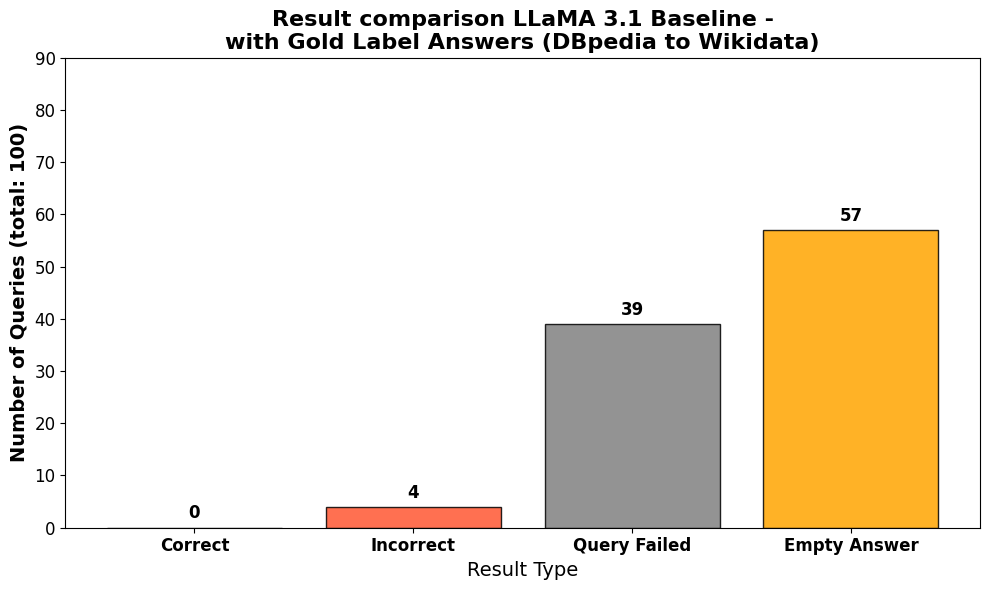

In [8]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
lama_output_file_path = "baseline_llama_dbpedia_wikidata_executed.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(lama_output_file_path, 'r') as f:
    lama_output_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['wikidata_results'] for entry in solution_data}

# Compare answers
total_questions = len(lama_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0

for lama_entry in lama_output_data:
    question = lama_entry.get("natural_language_question")
    lama_answers = lama_entry.get("answers", [])

    # Count query failures and no answers
    if "Query failed" in lama_answers:
        query_failed_count += 1
        continue
    if "No answer" in lama_answers:
        no_answer_count += 1
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(lama_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "lama_answers": lama_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

    # Count successful query executions (any result other than "Query failed")
    if lama_answers and "Query failed" not in lama_answers:
        successful_executions += 1

# Save the results to an Excel file for review
output_excel_file = "baseline_lama_dbpedia_wikidata_results_comparison.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0

# Calculate execution success rate (ESR)
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries (executed but wrong answer): {incorrect_count}")
print(f"Query Failed to execute: {query_failed_count}")
print(f"No Answer Queries (executed but empty answer): {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Execution Success Rate (ESR): {execution_success_rate:.2f}%")

# Visualize the results
categories = ['Correct', 'Incorrect', 'Query Failed', 'Empty Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['#4CAF50', '#FF5733', '#808080', '#FFA500']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result comparison LLaMA 3.1 Baseline -\nwith Gold Label Answers (DBpedia to Wikidata)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

# Enhance visual appeal
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, 90)

# Show the plot
plt.tight_layout()
plt.show()

### Comparison mistral-large-instruct with original output

Comparison completed. Results saved to 'baseline_mistral_dbpedia_wikidata_results_comparison.xlsx'.
Total Queries: 100
Correct Queries: 16
Incorrect Queries (executed but wrong answer): 14
Query Failed to execute: 16
No Answer Queries (executed but empty answer): 54
Accuracy: 16.00%
Execution Success Rate (ESR): 30.00%


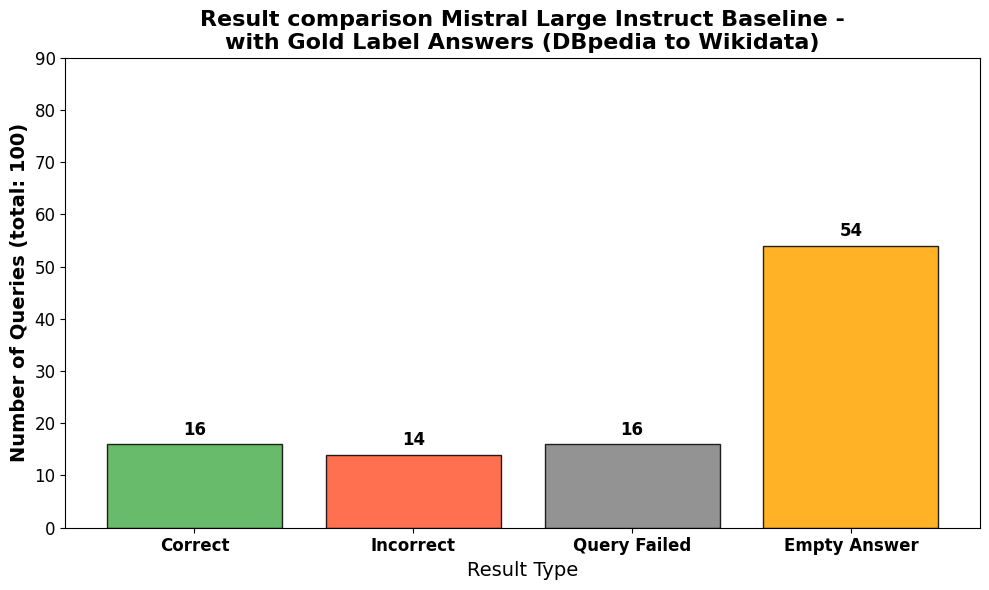

In [9]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
mistral_output_file_path = "baseline_mistral_dbpedia_wikidata_executed.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(mistral_output_file_path, 'r') as f:
    mistral_output_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['wikidata_results'] for entry in solution_data}

# Compare answers
total_questions = len(mistral_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0

for mistral_entry in mistral_output_data:
    question = mistral_entry.get("natural_language_question")
    mistral_answers = mistral_entry.get("answers", [])

    # Count query failures and no answers
    if "Query failed" in mistral_answers:
        query_failed_count += 1
        continue
    if "No answer" in mistral_answers:
        no_answer_count += 1
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(mistral_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "mistral_answers": mistral_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

    # Count successful query executions (any result other than "Query failed")
    if mistral_answers and "Query failed" not in mistral_answers:
        successful_executions += 1

# Save the results to an Excel file for review
output_excel_file = "baseline_mistral_dbpedia_wikidata_results_comparison.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0

# Calculate execution success rate (ESR)
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries (executed but wrong answer): {incorrect_count}")
print(f"Query Failed to execute: {query_failed_count}")
print(f"No Answer Queries (executed but empty answer): {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Execution Success Rate (ESR): {execution_success_rate:.2f}%")

# Visualize the results
categories = ['Correct', 'Incorrect', 'Query Failed', 'Empty Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['#4CAF50', '#FF5733', '#808080', '#FFA500']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result comparison Mistral Large Instruct Baseline -\nwith Gold Label Answers (DBpedia to Wikidata)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

# Enhance visual appeal
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')  
plt.yticks(fontsize=12)
plt.ylim(0, 90)

# Show the plot
plt.tight_layout()
plt.show()

In [1]:
import sys
import os

# Get the absolute path of the current working directory
current_dir = os.getcwd()

# Go two levels up to find the 'sparql_evaluation' folder
parent_dir = os.path.abspath(os.path.join(current_dir, "../../"))

# Set the project root manually as a fallback (adjust if necessary)
manual_project_root = os.path.abspath("Meine Ablage/Master Thesis/SPARQL-Query-Translation-QALD9/QALD9-Plus-testing")

# Ensure both paths are in sys.path
sys.path.append(parent_dir)
sys.path.insert(0, manual_project_root)

# Import the function
try:
    from sparql_evaluation.evaluate_wikidata import evaluate_wikidata_queries
    print("Import successful!")
except ModuleNotFoundError as e:
    print("Import failed:", e)

Import successful!


In [2]:
evaluate_wikidata_queries(
    input_file="baseline_llama_dbpedia_wikidata_extracted.json",
    output_excel="baseline_llama_wikidata_results_analysis.xlsx",
    query_key="sparql_query"
)

In [3]:
evaluate_wikidata_queries(
    input_file="baseline_mistral_dbpedia_wikidata_extracted.json",
    output_excel="baseline_mistral_wikidata_results_analysis.xlsx",
    query_key="sparql_query_kg2"
)